# Example: DC Resistivity

This example shows how to use `jInv` for solving a *small scale* DC resistivity inverse problem

\begin{equation*}
		\min_{m} \sum_{j} \| P_j^\top A(\sigma(m))^{-1} q_j - d_{j}\|^2 + \alpha \| L m\|^2 
        \quad \text{ subject to} \quad m_L \leq m \leq x_H,
\end{equation*}

where 

* $m$ - is the (scalar) conductivity model to be reconstructed
* $A$ - is a discretization of $\nabla \cdot (\sigma(m) \nabla)$
* $q_j$ - is the $j$th source
* $d_{j}$ - is the measured data for the $j$th source
* $P_j$ - is the receiver matrix applied to the $j$th field
* $\alpha>0$ and $L$ is the regularization parameter and operator, respectively
* $m_L,m_H$ are lower and upper bounds on the model

In this example, we assume that both the model and the PDE are discretized on regular meshes. We use the concept of *mesh decoupling*, that is, we solve the PDE on a coarse mesh so that $A$ can be efficiently factorized and the runtime of the inversion is kept to a minimum. 

### References

This experiment is also described in [1]. The test data here is generated using jInv and based on the 3D SEG/EAGE model of a salt reservoir described in [2]. Thus, please see and reference the following papers when using this example:

[1]  Ruthotto L, Treister E, Haber E: [jInv - a flexible Julia package for PDE parameter estimation](http://arxiv.org/abs/1606.07399), arXiv:1606.0739 [cs.MS] 2016

[2] F. Aminzadeh, B. Jean, and T. Kunz. 3-D salt and overthrust models. Society of Exploration Geophysicists, 1997.




In [1]:
using MAT
using PyPlot
using DivSigGrad
using jInv.InverseSolve
using jInv.Mesh
using jInv.LinearSolvers
using jInv.ForwardShare
using jInv.Utils
using jInvVis

## Load Data

Some test data is given in the mat file `exDCResistivity.mat`. 

In [2]:
matfile   = matread("exDCResistivity.mat")
Receivers = matfile["Receivers"]  # sparse matrix of discretized receivers
Sources   = matfile["Sources"] # sparse matrix of discretized sources
dobs      = matfile["dobs"]    # observations simulated with true model
dobs0     = matfile["dobs0"]   # observations simulated for reference model
n         = matfile["n"]       # size of mesh used for the model
nfwd      = matfile["nfwd"]    # size of mesh used to solve PDEs
domain    = matfile["domain"]  # description of physical domain
sigref    = matfile["sigref"]  # reference guess for conductivities
mref      = matfile["mref"];   # reference guess for model;

## Visualize Data

Here, we visualize the measured data for some selected sources. We compare the simulated with the true conductivities to data acquired for homogeneous conductivities. This way we can get a first feeling for the data and see anomalies in the ground.

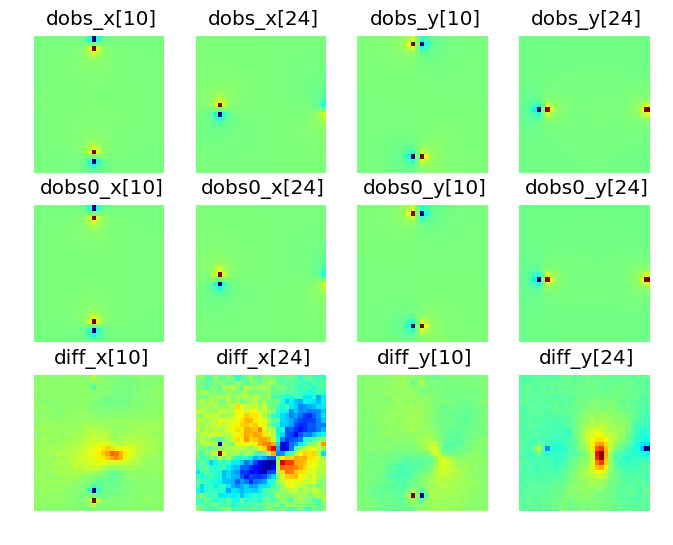

In [3]:
ids = [10 24] #pick sources you want to see

MD = getRegularMesh(domain[1:4],[29 29])
viewD(data) = (viewImage2D(data,MD); axis("off"))
subplot(3,4,1)
viewD(dobs[1:841,ids[1]])
title("dobs_x[$(ids[1])]")
subplot(3,4,2)
viewD(dobs[1:841,ids[2]])
title("dobs_x[$(ids[2])]")
subplot(3,4,3)
viewD(dobs[842:end,ids[1]])
title("dobs_y[$(ids[1])]")
subplot(3,4,4)
viewD(dobs[842:end,ids[2]])
title("dobs_y[$(ids[2])]")

subplot(3,4,5)
viewD(dobs0[1:841,ids[1]])
title("dobs0_x[$(ids[1])]")
subplot(3,4,6)
viewD(dobs0[1:841,ids[2]])
title("dobs0_x[$(ids[2])]")
subplot(3,4,7)
viewD(dobs0[842:end,ids[1]])
title("dobs0_y[$(ids[1])]")
subplot(3,4,8)
viewD(dobs0[842:end,ids[2]])
title("dobs0_y[$(ids[2])]")

subplot(3,4,9)
viewD((dobs-dobs0)[1:841,ids[1]])
title("diff_x[$(ids[1])]")
subplot(3,4,10)
viewD((dobs-dobs0)[1:841,ids[2]])
title("diff_x[$(ids[2])]")
subplot(3,4,11)
viewD((dobs-dobs0)[842:end,ids[1]])
title("diff_y[$(ids[1])]")
subplot(3,4,12)
viewD((dobs-dobs0)[842:end,ids[2]])
title("diff_y[$(ids[2])]");

*Interpretation : * comparing the first and second row (see also the difference plot) we can see that the simulated data differs when using the true and a reference model for the conductivity. This is a good starting point for the inversion. In fact, the difference image hints that there is an anomaly in the center of the domain.

## Setup Meshes for Forward and Inverse Problem

Using mesh decoupling allows using different meshes for the model and the fields. In this case, the fields are computed on a coarser mesh. Of course, we need an interpolation matrix that maps fine mesh quantities to the coarse mesh.

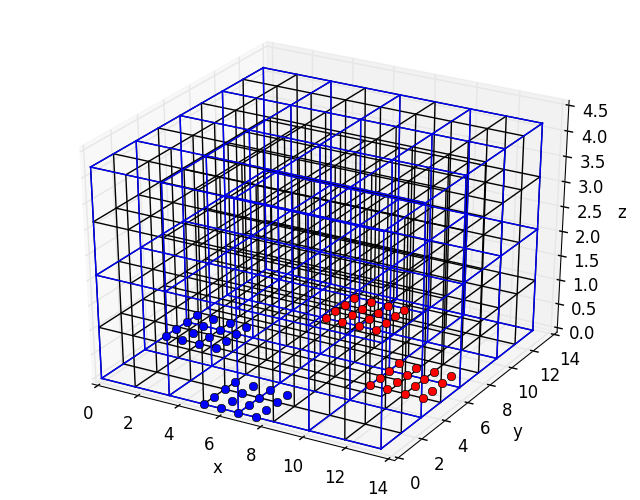

In [4]:
Minv        = getRegularMesh(domain,n);
Mfwd        = getRegularMesh(domain,nfwd);
Mesh2Mesh   = getInterpolationMatrix(Minv,Mfwd)';

plotGrid(getNodalGrid(Minv),Minv,spacing=[8 8 8],color="k")
hold(true)
plotGrid(getNodalGrid(Mfwd),Mfwd,spacing=[8 8 8],color="b")
xlabel("x"); ylabel("y");zlabel("z");

# plot the source locations
xc = getNodalGrid(Mfwd);
id = find(sum(max(Sources,0),2).==1)
plot3D(xc[id,1],xc[id,2],xc[id,3],"or");
id = find(sum(min(Sources,0),2).==-1)
plot3D(xc[id,1],xc[id,2],xc[id,3],"ob");


## Selecting the Active Set

Sometimes we want to include some voxels from the inversion (for example, close to the boundary / sources / receivers). This can be done by the matrix `Iact` by deleting some columns from a sparse identity matrix. If we do that, the size of the model gets smaller and so we need to update the reference model as well.

In [5]:
Iact  = speye(Bool,prod(n))
mref  = Iact'*mref[:]
mback = mref - Iact*(Iact'*mref);

## Setup Misfit Param

Here we set up the misfit param for the `DivSigGrad` problem. Since we use a relatively coarse mesh for solving the PDEs we use MUMPS to factorize the discrete PDE and solve it for all sources. Also we define a model function for this problem. We use only a single misfit param, which means there is no parallelization involved in this example (except for the one in `MUMPS.jl`)

In [6]:
Ainv        = getMUMPSsolver()  # choose MUMPS as a PDE solver
pFor        = DivSigGradParam(Mfwd, Sources, Receivers, [], Ainv)
sigback     = vec(sigref - Iact*(Iact'*sigref))
gloc        = GlobalToLocal(Iact'*Mesh2Mesh,Mesh2Mesh'*sigback);
Wt          = 1./(mean(abs(vec(dobs)))/2+abs(dobs));
dobs       += 0.01*randn(size(dobs))*mean(abs(vec(dobs))) # add noise
pMis        = getMisfitParam(pFor,Wt,dobs,SSDFun,identityMod,gloc);

## Configure the Inversion

In this block we set parameters for the inversion. In jInv we need to select a regularizer, its parameter, and configer the optimization problem by setting upper and lower bounds, maximum number of iterations for the outer and inner loop, a preconditioner, and a model. 

In [7]:
# configure regularization
alpha	   	= 1e-15;
regparams   = [1.0,1.0,1.0,1e-6];
regfun(m,mref,Minv) = wdiffusionReg(m,mref,Minv,Iact=Iact,C = regparams)

# configure optimization
HesPrec     = getSSORRegularizationPreconditioner(1.0,1e-15,200);
cgit       	= 10; 
pcgTol     	= 1e-1;
maxIter    	= 10;
minUpdate 	= 1e-2;
boundsLow  	= 1.45*ones(size(Iact,2));
boundsHigh 	= 4.5 *ones(size(Iact,2));
maxStep		= 0.1*maximum(boundsHigh);

# configure model function
function velToConductMod(v,mid,a,b)
  d = (b-a)./2.0;
  dinv = 10;
  tt = dinv.*(mid - v);
  t = (d.*(tanh(tt)+1) + a);
  dt = -(dinv*d)*(sech(tt)).^2;
  dt = (2.0-v./mid).*dt + (-1./mid).*t;
  t = t.*(2.0-v./mid);
  return vec(t),spdiagm(vec(dt))
end

modfunDC(m) = velToConductMod(m,3.0,0.1,1.0);
pInv = getInverseParam(Minv,modfunDC,regfun,alpha,vec(mref),
         boundsLow,boundsHigh,maxStep=maxStep,pcgMaxIter=cgit,pcgTol=pcgTol,
         minUpdate=minUpdate, maxIter = maxIter,HesPrec=HesPrec);

## Choose Method for Plotting/Storing Intermediate Results

Some inversions might take a long time, so it's useful to store or visualize intermediate results. This way, we can cancel the inversion if, e.g., the regularization parameter is too large/small. The optimization algorithms in jInv provide the current model, the current data and some other info we can use. In this case we just plot the true sigma and the estimated sigma for comparison

*Remark : * interactive plotting does not work in IJulia notebooks. However, if you copy the code to a `.jl` file you will be able to see the plots being updated through the iteration.

In [8]:
plotting = true
function plotIntermediates(mc,Dc,iter,pInv,pMis)
	figure(13)
	clf()
	subplot(1,2,1)
    viewOrthoSlices2D(mref,Minv)
    title("starting guess")
	colorbar()
	subplot(1,2,2)
	viewOrthoSlices2D(Iact*vec(mc)+mback,Minv)
    title("mc at iter=$(iter)")
	colorbar()
end

plotIntermediates (generic function with 1 method)

## Finally: Run the Inversion


i.LS	       F	       R	alpha[1]	   Jc/J0	 #Active
  1.0	1.02e+02	0.00e+00	1.00e-15	1.00e+00	  0
   .1	9.09e+01	1.12e-15			8.91e-01
  2.0	9.09e+01	1.12e-15	1.00e-15	8.91e-01	  0
   .1	7.99e+01	4.59e-15			7.84e-01
  3.0	7.99e+01	4.59e-15	1.00e-15	7.84e-01	  0
   .1	6.12e+01	1.07e-14			6.01e-01
  4.0	6.12e+01	1.07e-14	1.00e-15	6.01e-01	  0
   .1	3.58e+01	2.54e-14			3.51e-01
  5.0	3.58e+01	2.54e-14	1.00e-15	3.51e-01	 32
   .1	2.36e+01	3.92e-14			2.32e-01
  6.0	2.36e+01	3.92e-14	1.00e-15	2.32e-01	 98
   .1	1.59e+01	5.28e-14			1.56e-01
  7.0	1.59e+01	5.28e-14	1.00e-15	1.56e-01	190
   .1	1.20e+01	6.63e-14			1.17e-01
  8.0	1.20e+01	6.63e-14	1.00e-15	1.17e-01	203
   .1	9.81e+00	8.11e-14			9.62e-02
  9.0	9.81e+00	8.11e-14	1.00e-15	9.62e-02	246
   .1	8.45e+00	1.02e-13			8.29e-02
 10.0	8.45e+00	1.02e-13	1.00e-15	8.29e-02	322
   .1	7.69e+00	1.28e-13			7.55e-02
projGNCG iterated maxIter=10 times but reached only stepNorm of 0.4500000000000002 instead 0.01.

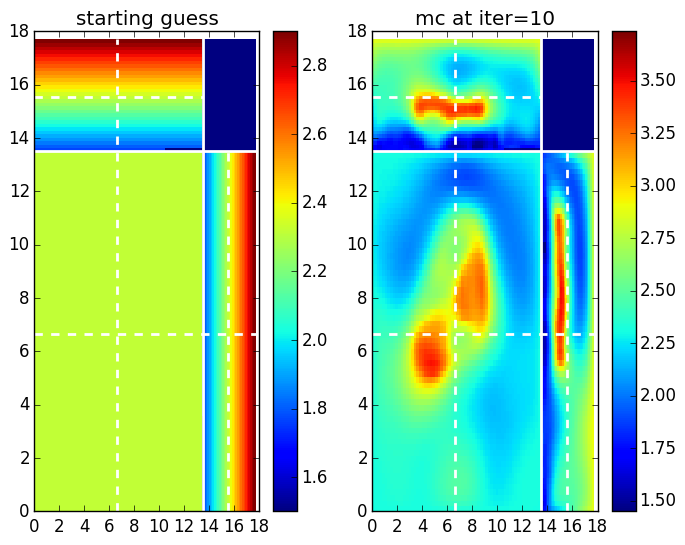

In [9]:
mc,Dc,flag,His = projGNCG(copy(mref[:]),pInv,pMis,dumpResults = plotIntermediates);

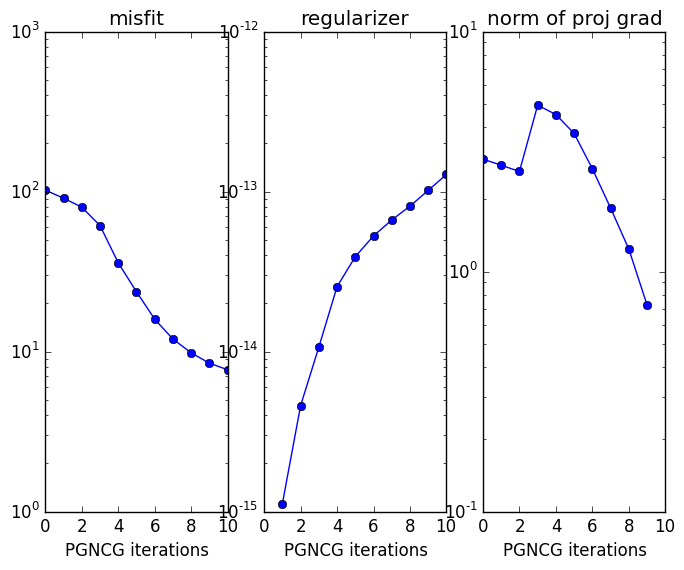

In [10]:
subplot(1,3,1)
semilogy(His.F,"-o")
xlabel("PGNCG iterations")
title("misfit")

subplot(1,3,2)
semilogy(His.Rc,"-o")
xlabel("PGNCG iterations")
title("regularizer");

subplot(1,3,3)
semilogy(His.dJ,"-o")
xlabel("PGNCG iterations")
title("norm of proj grad");

## Visualize residuals

After running the inversion, we should check whether the estimated solution fits the data well. Therfore, we recommend plotting the residual. Here, we do that for a subset of the sources. 


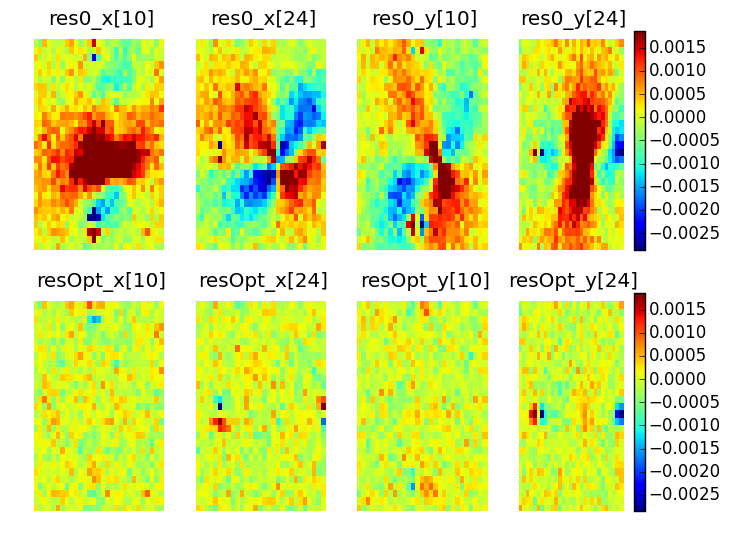

In [22]:
ids = [10 24] #pick sources you want to see

MD = getRegularMesh(domain[1:4],[29 29])
viewD(data) = (viewImage2D(data,MD,vmin=.1*minimum(dobs-dobs0),vmax=.1*maximum(dobs-dobs0)); axis("off"))


subplot(2,4,1)
viewD((dobs-dobs0)[1:841,ids[1]])
title("res0_x[$(ids[1])]")
subplot(2,4,2)
viewD((dobs-dobs0)[1:841,ids[2]])
title("res0_x[$(ids[2])]")
subplot(2,4,3)
viewD((dobs-dobs0)[842:end,ids[1]])
title("res0_y[$(ids[1])]")
subplot(2,4,4)
viewD((dobs-dobs0)[842:end,ids[2]])
title("res0_y[$(ids[2])]"); colorbar()

subplot(2,4,5)
viewD((dobs-Dc)[1:841,ids[1]])
title("resOpt_x[$(ids[1])]")
subplot(2,4,6)
viewD((dobs-Dc)[1:841,ids[2]])
title("resOpt_x[$(ids[2])]")
subplot(2,4,7)
viewD((dobs-Dc)[842:end,ids[1]])
title("resOpt_y[$(ids[1])]")
subplot(2,4,8)
viewD((dobs-Dc)[842:end,ids[2]])
title("resOpt_y[$(ids[2])]"); colorbar();

## Optional: Save your results


In [23]:
His.Dc = [];
matwrite("exDCResistivityRes.mat",Dict("mc"=>mc,"His"=>His,"Dc"=>Dc))